**thank You Yassine Gouzham, PhD**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
#convert to one-hot-encodng
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


**Data Preparation**

In [3]:
#Load Data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

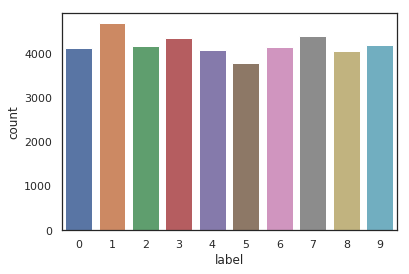

In [4]:
Y_train = train["label"]

X_train = train.drop(labels=['label'],axis=1)

del train

g= sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
#Check for null and Missing Values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
#Grayscale normalization to reduce the effect of illumination's differences (CNN converge faster on [0,1] than [0,255])
X_train = X_train/255.0
test=test/255.0

In [8]:
#Reshape image in 3 dimension (height=28px,width=28px,canal=1)
X_train = X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [9]:
#labelEncoding to one hot vector (e.g. 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train=to_categorical(Y_train, num_classes=10)

In [10]:
#split train and the validation dataset
random_seed=2
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train,test_size=0.1, random_state=random_seed)

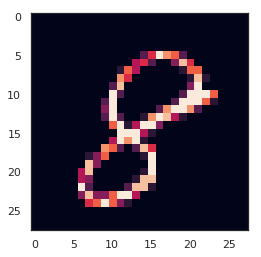

In [11]:
g = plt.imshow(X_train[0][:,:,0])

**CNN**

In [12]:
#settheCNN model
# CNN architecture -> [[Con2D ->relu]*2 -> maxPool2D -> Dropout]*2->Flatten->Dense->Dropout->out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=(5,5), padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters = 32, kernel_size=(5,5), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [13]:
#Define optimizer
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay =0.0)

In [14]:
#compile the model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=["accuracy"])

In [15]:
#set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 3, verbose=1, factor=0.5, min_lr=0.00001)

In [16]:
epoch = 3
batch_size = 86

In [17]:
#Data Augmentation
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False
                            , samplewise_std_normalization=False, zca_whitening=False, rotation_range=10, zoom_range=0.1,
                            width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False, vertical_flip=False)

datagen.fit(X_train)

In [18]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                             epochs=epoch, validation_data=(X_val,Y_val),
                             verbose=2, steps_per_epoch=X_train.shape[0], callbacks=[learning_rate_reduction])

Epoch 1/3
 - 999s - loss: 0.1300 - accuracy: 0.9752 - val_loss: 0.3823 - val_accuracy: 0.9888
Epoch 2/3


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 971s - loss: 0.2655 - accuracy: 0.9546 - val_loss: 0.1796 - val_accuracy: 0.9836
Epoch 3/3
 - 956s - loss: 1.1857 - accuracy: 0.9364 - val_loss: 0.0835 - val_accuracy: 0.9857


**Evaluate The Model**

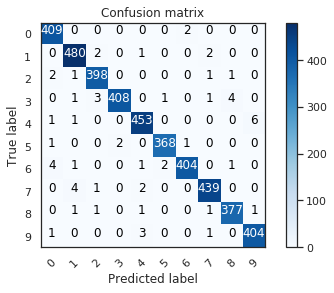

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [22]:
results= model.predict(test)

results = np.argmax(results,axis=1)

results = pd.Series(results, name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results],axis=1)

submission.to_csv("CNN_MNIST.csv", index=False)